In [2]:
from deps.data import load_raw_data

raw_data = load_raw_data()

In [2]:
visit_time_offset = raw_data \
    .groupby('IDNR') \
    .filter(lambda group: len(group) > 1) \
    .groupby('IDNR') \
    .apply(lambda group: group.iloc[0]['DVISIT'] <  group.iloc[1]['DVISIT'])

In [3]:
raw_data[raw_data['IDNR'].isin(visit_time_offset[visit_time_offset == False].index_data)]

,IDNR,STUDY,STUDY_NUM,LOCALID,VISIT,DVISIT,DBIRTH,SEX,AGE,BW,...,P3NP,MOS_ID,EVALUATION_ID,ACSP75,CAD238,HF1,HFREF103,HFREF_CKD,LVHFP,HF2
22350,6000344,FLEMENGHO,6,2146,Baseline,NaT,1950-11-07,2.0,54.904860,56.0,...,9.088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22351,6000344,FLEMENGHO,6,2146,FU visit2,2010-03-08,1950-11-07,2.0,59.331964,60.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40619,17000009,REVE-1,17,01/010,Baseline,2003-03-10,NaT,1.0,57.000000,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40620,17000009,REVE-2,17,BOU/001,Baseline,2002-03-29,NaT,1.0,81.000000,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40621,17000010,REVE-1,17,01/011,Baseline,2003-05-12,NaT,1.0,50.000000,82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45501,18001937,STANISLAS,18,5167,FU visit2,1999-07-07,1955-04-11,2.0,44.200000,56.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45502,18001937,STANISLAS,18,5167,FU visit4,2011-10-13,1955-04-11,2.0,56.000000,57.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46091,18002197,STANISLAS,18,57211,Baseline,NaT,1960-02-23,1.0,35.200000,64.2,...,6.718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46092,18002197,STANISLAS,18,57211,FU visit2,2000-04-25,1960-02-23,1.0,40.200000,64.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


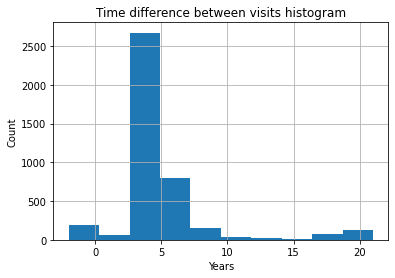

In [4]:

from matplotlib import pyplot

g = raw_data.groupby('IDNR')

visit_time_offset = g \
    .filter(lambda group: len(group) > 1) \
    .groupby('IDNR') \
    .apply(lambda group: group.iloc[1]['DVISIT'] - group.iloc[0]['DVISIT']) \

visit_time_offset.astype('timedelta64[Y]').hist()
pyplot.title('Time difference between visits histogram')
pyplot.xlabel('Years')
pyplot.ylabel('Count')
pyplot.show()

In [ ]:
# from hcve_lib.data import format_features_and_values, format_values
# import pandas
# import plotly.graph_objects as go
#
# data_formatted = format_values(data, metadata)
# df = data_formatted.groupby([data_formatted['STUDY_NUM'], pandas.cut(data['AGE'], 60, precision=0)])
# df = df.size().unstack().apply(lambda s: s,axis=1)
#
# y_ticks = list(df.index_data)
# x_ticks = [ c.left for c in df.columns]
#
# fig = go.Figure(data=[go.Surface(x=x_ticks, y=y_ticks, z=df, showscale = False)])
#
# fig.update_layout(
#     autosize=True,
#     font={
#         'size': 13,
#     },
#     width=700,
#     height=600,
#     scene=dict(
#         xaxis_title=format_identifier('AGE', metadata),
#         yaxis_title='Study',
#         zaxis_title='Probability mass (given year)',
#     ),
#     scene_camera=dict(
#         up=dict(x=5, y=0, z=10),
#         center=dict(x=0, y=0, z=-0.15),
#         eye=dict(x=1.3, y=1.3, z=1.3)
#     ),
#     margin=go.layout.Margin(l=0, r=0, b=0, t=0)
# )
# fig.update_yaxes(type='category')
# fig.show()

In [ ]:
def get_cohort(X, data, cohort_name):
    selected_index = data[(data['STUDY'] == cohort_name)].index
    X_selected = X.loc[selected_index]
    return X_selected

# LM ASCOT

In [ ]:
from pipelines import get_pipelines

coxnet = get_pipelines()['coxnet']


X_train = get_cohort(X, data, 'ASCOT')
y_train = {**y, 'data': y['data'].loc[X_train.index]}

test_index = data[(data['STUDY'] != 'ASCOT')].index
X_test = X.loc[test_index]
y_test = {**y, 'data': y['data'].loc[test_index]}

In [ ]:
pipeline = coxnet.get_estimator(X, verbose=True)
pipeline.fit(X_train, y_train)

In [ ]:
from pandas import Series

y_predict = Series(pipeline.predict(X_test), index=y_test['data'].index)

In [ ]:
from sksurv.metrics import concordance_index_censored

concordance_index_censored(
    y_test['data']['label'].astype(bool),
    y_test['data']['tte'],
    y_predict
)

In [ ]:
y_test['data']['label'].astype(bool)

In [ ]:
y_predict.value_counts()

# LCO ASCOT

In [ ]:
from pipelines import get_pipelines
from pandas import Series

coxnet = get_pipelines()['coxnet']

X_test = get_cohort(X, data, 'ASCOT')
y_test = {**y, 'data': y['data'].loc[X_test.index]}

train_index = data[(data['STUDY'] != 'ASCOT')].index
X_train = X.loc[train_index]
y_train = {**y, 'data': y['data'].loc[train_index]}

pipeline = coxnet.get_estimator(X, verbose=True)
pipeline.fit(X_train, y_train);

In [ ]:
y_predict = Series(pipeline.predict(X_test), index=y_test['data'].index)

from sksurv.metrics import concordance_index_censored

print(concordance_index_censored(
    y_test['data']['label'].astype(bool),
    y_test['data']['tte'],
    y_predict
))

In [ ]:
y_test['data']['label'].astype(bool)

In [ ]:
y_predict.hist(bins=40)

When using only ASCOT for training the prediction is not working, many same value scores


In [ ]:
from hcve_lib.data import format_identifier, format_features_and_values


def plot_coefficients(coefs, n_highlight):
    _, ax = pyplot.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        pyplot.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

cox_elastic_net = pipeline[-1].inner
coefficients_elastic_net = DataFrame(
    cox_elastic_net.coef_,
    index=format_features_and_values(X_train, metadata).columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [ ]:
def test_score(*args, **kwargs):
    print(args)
    print(kwargs)
    ...

In [ ]:
from pipelines import get_pipelines

coxnet = get_pipelines()['coxnet']


X_train = get_cohort(X, data, 'ASCOT')
y_train = {**y, 'data': y['data'].loc[X_train.index]}

test_index = data[(data['STUDY'] != 'ASCOT')].index
X_test = X.loc[test_index]
y_test = {**y, 'data': y['data'].loc[test_index]}

alphas = []
c_indexes = []
for alpha in pipeline[-1].inner.alphas_:
    pipeline.fit(X_train, y_train)
    y_predict = Series(pipeline.predict(X_test, alpha=alpha), index=y_test['data'].index)
    alphas.append(alpha)
    c_indexes.append(concordance_index_censored(
        y_test['data']['label'].astype(bool),
        y_test['data']['tte'],
        y_predict
    )[0])

In [ ]:
pyplot.plot(alphas, c_indexes)


In [17]:
from IPython.core.display import display
from deps.common import get_variables_cached
from hcve_lib.wrapped_sklearn import DFBinMapper

data, metadata, X, y = get_variables_cached()

binner = DFBinMapper(n_bins=10)
display(X)
X_trans = binner.fit_transform(X, y)
X_trans

,SEX,AGE,BW,BH,BMI,SMK,DRK,DIABETES,HCV,HCAD,...,PP,SOK,QRS,CI,GLU,CHOL,LDL,HDL,TG,CREA
IDNR,,,,,,,,,,,,,,,,,,,,,
2000001,1.0,67.572895,100.3,173.0,33.512647,1.0,1.0,0.0,0.0,0.0,...,42.5,18.5,90.0,1440.0,5.60000,2.900000,1.185000,1.400000,0.70000,NaN
2000002,1.0,50.828200,83.1,173.0,27.765712,2.0,1.0,1.0,0.0,0.0,...,42.5,19.5,86.0,1763.0,6.90000,6.000000,3.215000,1.300000,3.30000,124.000
2000003,1.0,74.203970,74.0,167.0,26.533759,0.0,1.0,0.0,0.0,0.0,...,88.0,27.0,90.0,1845.0,5.80000,6.500000,4.195000,1.900000,0.90000,94.000
2000004,1.0,67.857632,87.0,188.0,24.615211,2.0,1.0,1.0,1.0,0.0,...,79.0,20.5,90.0,1215.0,NaN,5.000000,NaN,0.900000,NaN,102.000
2000005,2.0,73.240246,59.0,162.0,22.481329,1.0,1.0,1.0,1.0,0.0,...,80.0,26.0,80.0,1840.0,14.20000,5.700000,3.305000,1.000000,3.10000,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624474,2.0,49.772727,90.1,162.5,34.120710,0.0,0.0,0.0,0.0,0.0,...,51.6,17.2,80.0,1080.0,3.99672,4.060310,2.405152,1.008612,1.38867,68.068
624475,1.0,53.277656,83.9,186.0,24.251359,0.0,1.0,0.0,0.0,0.0,...,30.8,38.6,94.0,1287.8,4.66284,4.784442,2.741356,1.706882,0.74514,77.792
624478,1.0,47.866922,77.4,182.0,23.366743,0.0,0.0,0.0,0.0,0.0,...,32.0,20.8,90.0,1179.0,4.55182,3.439626,1.965500,1.086198,0.82417,82.212


,SEX,AGE,BW,BH,BMI,SMK,DRK,DIABETES,HCV,HCAD,...,PP,SOK,QRS,CI,GLU,CHOL,LDL,HDL,TG,CREA
IDNR,,,,,,,,,,,,,,,,,,,,,
2000001,0,4,8,5,7,1,1,0,0,0,...,0,2,3,3,5,0,0,5,0,9
2000002,0,0,5,5,4,2,1,1,0,0,...,0,2,2,5,7,5,3,4,8,8
2000003,0,6,3,3,3,0,1,0,0,0,...,7,6,3,5,5,6,6,8,1,4
2000004,0,4,6,8,2,2,1,1,1,0,...,6,3,3,2,9,2,9,0,9,5
2000005,1,6,0,1,0,1,1,1,1,0,...,6,5,0,5,8,4,3,1,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624474,1,0,6,2,8,0,0,0,0,0,...,1,1,0,1,0,0,0,2,3,0
624475,0,0,5,8,1,0,1,0,0,0,...,0,8,4,2,1,1,1,7,0,1
624478,0,0,3,8,1,0,0,0,0,0,...,0,3,3,2,0,0,0,2,0,2
